In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import  RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error

from sklearn.tree import plot_tree

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Cart Sim Data

Note: sklearn's DecisionTreeClassifier is a modified/advanced version of CART.

In [2]:
from itertools import product

per_spot = 5
grid_points = [(x, y) for x in range(1, 7) for y in np.arange(1, 4.75, 0.75)]

data_train = []
for x, y in grid_points:
    base_points = np.tile([x, y], (per_spot, 1))
    noise = np.random.normal(0,1.0, (per_spot, 2)) # 0.15
    data_train.append(pd.DataFrame(base_points + noise, columns=['x1', 'x2']))

data_train = pd.concat(data_train, ignore_index=True)

data_train['class'] = np.where(data_train['x1'] > 3.5, 0,
                               np.where((data_train['x1'] <= 3.5) & (data_train['x2'] >= 2.3), 0, 1))

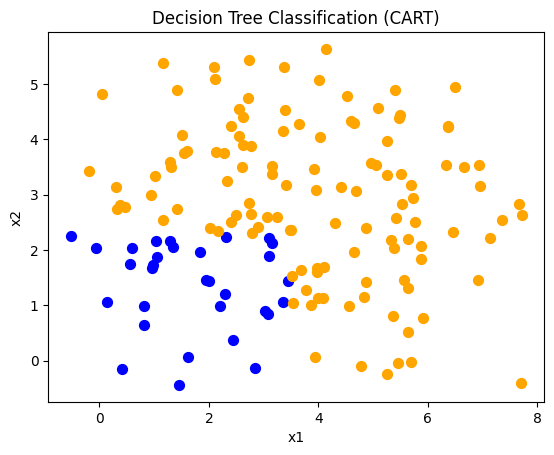

In [3]:
fig, ax = plt.subplots()

colors = ['blue', 'orange'] 
for i, class_val in enumerate(data_train['class'].unique()):
    class_data = data_train[data_train['class'] == class_val]
    ax.scatter(class_data['x1'], class_data['x2'], c=colors[i], s=50) 

#ax.axhline(2.2, color='black', linestyle='--')
#ax.axvline(3.5, color='black', linestyle='--')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Decision Tree Classification (CART)')
plt.show()

In [4]:
clf = DecisionTreeClassifier(criterion='gini', min_samples_split=5, min_samples_leaf=1)
clf.fit(data_train[['x1', 'x2']], data_train['class'])

DecisionTreeClassifier(min_samples_split=5)

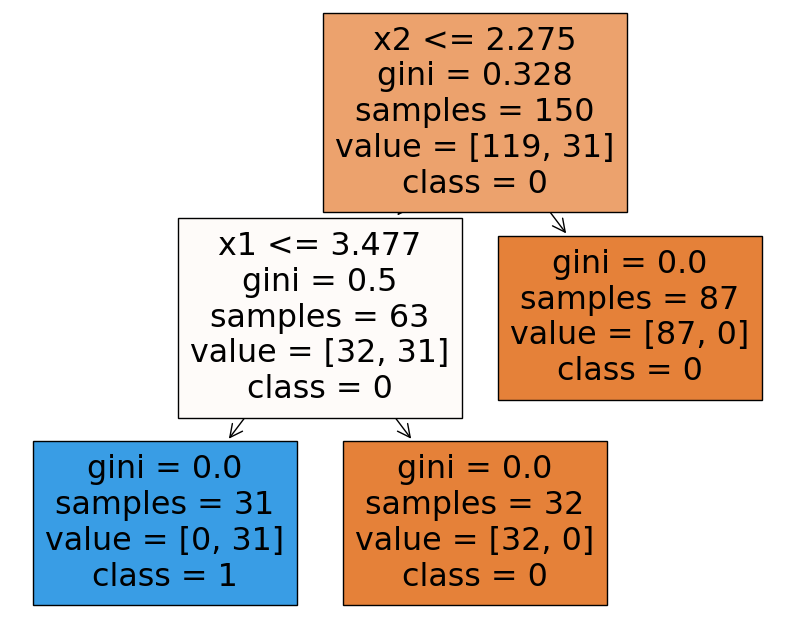

In [5]:
plt.figure(figsize=(10,8))
plot_tree(clf, filled=True, feature_names=['x1', 'x2'], class_names=["0", "1"])
plt.show()

## Add just a few data points

just a few points change the result drastically. Its not hard to see why we need methods such as pruning to avoid having a too complex tree (overfitting) in practice

In [6]:
new_points = [
    [3.9, -0.6],  
    [4.6, -0.76],
    [4.3, -0.4], 
    [4.6, -0.66]
]
new_df = pd.DataFrame(new_points, columns=['x1', 'x2'])
new_df['class'] = 1  # Change according to simulated data..

data_train2 = pd.concat([data_train, new_df], ignore_index=True) 

clf = DecisionTreeClassifier(criterion='gini', min_samples_split=5, min_samples_leaf=1)
clf.fit(data_train2[['x1', 'x2']], data_train2['class']) 

DecisionTreeClassifier(min_samples_split=5)

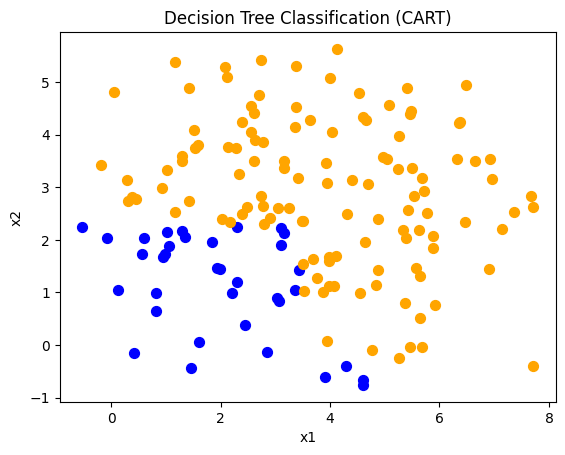

In [7]:
fig, ax = plt.subplots()

colors = ['blue', 'orange'] 
for i, class_val in enumerate(data_train2['class'].unique()):
    class_data = data_train2[data_train2['class'] == class_val]
    ax.scatter(class_data['x1'], class_data['x2'], c=colors[i], s=50) 


#ax.axhline(2.2, color='black', linestyle='--')
#ax.axvline(3.5, color='black', linestyle='--')

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Decision Tree Classification (CART)')
plt.show()

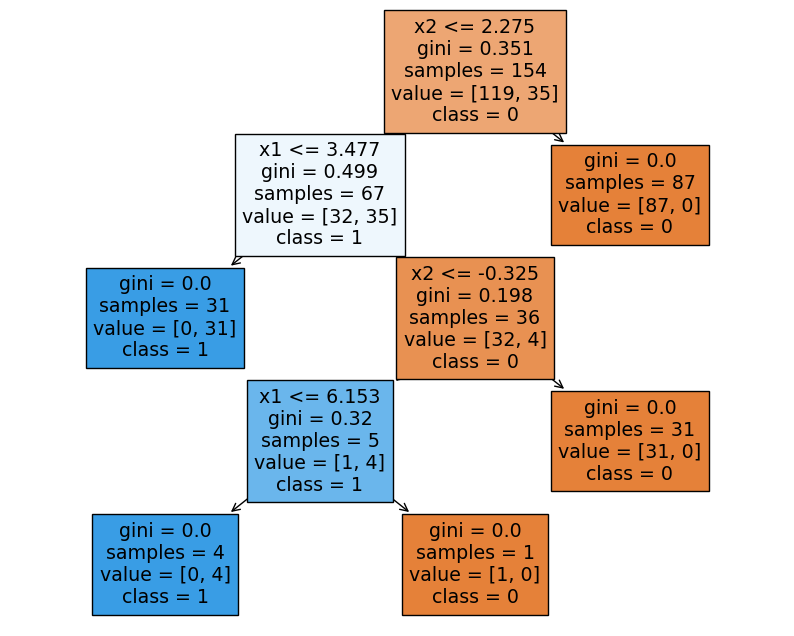

In [8]:
plt.figure(figsize=(10,8))
plot_tree(clf, filled=True, feature_names=['x1', 'x2'], class_names=["0", "1"])
plt.show()

# Random Forest
- Showcase the basics of data analysis using random forest.
- Note that in sklearn the default of "max_features = 1.0" correspons to bagged trees!

In [9]:
from sklearn.datasets import load_iris, fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score

In [10]:
# see: https://scikit-learn.org/stable/datasets/real_world.html#california-housing-dataset
data = fetch_california_housing()

# target (y) is  median house value
X, y = data.data, data.target

if True: # Reduce data set to make it faster.
    X = X[0:5000]
    y = y[0:5000]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

print(np.shape(X))

print(data.feature_names)

(5000, 8)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [11]:
# check if missing
print('any missing?:', np.isnan(X).any())

any missing?: False


In [12]:
# simple baseline mse to beat

mean_y_train = np.mean(y_train)
y_baseline = np.ones(len(y_test))*mean_y_train

print('baseline MSE:', mean_squared_error(y_baseline, y_test))

baseline MSE: 1.1856067512505715


In [13]:
max_features_range = np.linspace(0.1, 1.0, 10)#np.linspace(10, 200, 10) # 
cv_scores = []
std_devs = []

for max_features in max_features_range:
    rf = RandomForestRegressor(n_estimators=100, max_features=max_features, random_state=123)
    #rf = RandomForestRegressor(n_estimators=int(max_features), random_state=123) 

    # Note because of  sklearn convention we use -MSE
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error') 
    cv_scores.append(-scores.mean()) #convert to mse 
    std_devs.append(scores.std())

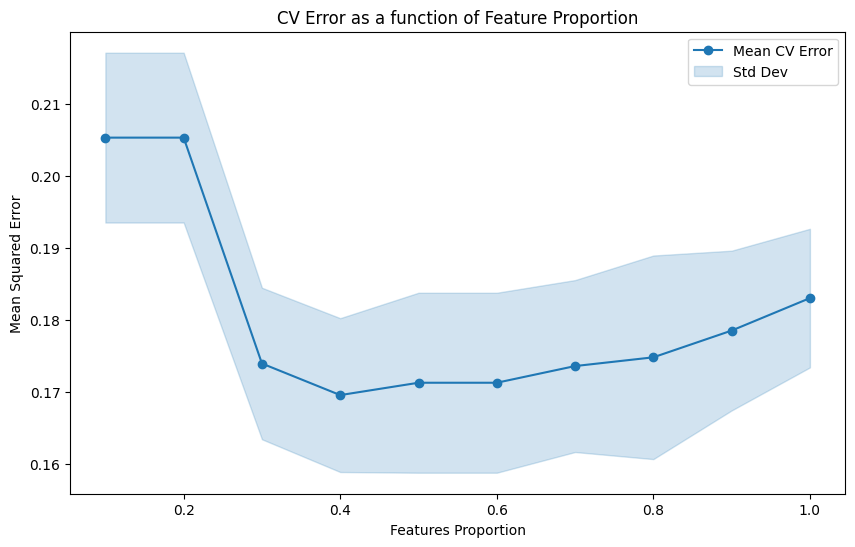

In [14]:
cv_scores_np = np.array(cv_scores)
std_devs_np = np.array(std_devs)

plt.figure(figsize=(10, 6))
plt.plot(max_features_range, cv_scores, '-o', label='Mean CV Error', color='tab:blue')
plt.fill_between(max_features_range, cv_scores_np - std_devs_np, cv_scores_np + std_devs_np, color='tab:blue', alpha=0.2, label='Std Dev')

plt.xlabel('Features Proportion')
plt.ylabel('Mean Squared Error')
plt.title('CV Error as a function of Feature Proportion')
plt.legend()
plt.show()

# Note You can use CI instead of standard dev. It might actually be preferable, as it can be easier to interpret.
# 1.0 = bagged cart

In [15]:
best_index = np.argmin(cv_scores)
best_max_features = max_features_range[best_index]

# Fit model on entire training data
rf_best = RandomForestRegressor(n_estimators=100, max_features=best_max_features, random_state=42)
rf_best.fit(X_train, y_train)

# Present results for test data, that we set aside initally
y_pred = rf_best.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)

print('best_max_features', best_max_features)
print('test mse', test_mse.round(3))

best_max_features 0.4
test mse 0.165
